
# CarND Vehicle Detection project - P5
***

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import cv2
import os
import glob
import pandas as pd

#from utils_vehicles import *

In [2]:
!ls

FrameOut.py                    pipelineTestImage.ipynb
FrameOut2.py                   project
LICENSE                        project_video.mp4
Parameter.py                   result_images
README.md                      sample_data
X_test.npy                     search_windows.py
X_train.npy                    svc_train.py
__pycache__                    test
cars.csv                       test_images
examples                       test_video.mp4
find_car.ipynb                 trainDataClass.py
my_rf_classifier.pkl           utils_vehicles.py
my_svc_classifier.pkl          vehicle_data_exploration.ipynb
my_writeup.md                  vehicles.zip
non-vehicles.zip               y_test.npy
noncars.csv                    y_train.npy
output_images


## Read Vehicle data 

In [3]:
vehicle_base = "./sample_data/vehicles"
vehicle_dirs = os.listdir(vehicle_base)
vehicle_dirs = [v for v in vehicle_dirs if "DS_Store" not in v]

In [4]:
cars = []
for im_type in vehicle_dirs:
    target_dir = os.path.join( vehicle_base, im_type )
    target_dir = os.path.join( target_dir , "*")
    files = glob.glob( target_dir  )
    cars.extend(files)

In [5]:
car_filename =    [car.split("/")[-1] for car in cars]

In [6]:
print("Number of Cars Data ..", len(cars))

Number of Cars Data .. 8792


## Read Non Vehicle data

In [7]:
non_vehicle_base = "./sample_data/non-vehicles"
non_vehicle_dirs = os.listdir(non_vehicle_base)
non_vehicle_dirs = [v for v in non_vehicle_dirs if "DS_Store" not in v]

In [8]:
non_cars = []
for im_type in non_vehicle_dirs:
    target_dir = os.path.join( non_vehicle_base, im_type )
    target_dir = os.path.join( target_dir , "*")
    files = glob.glob( target_dir  )
    non_cars.extend(files)

In [9]:
non_car_filename = [ncar.split("/")[-1] for ncar in non_cars]

In [10]:
print("Number of Non Cars Data ..", len(non_cars))

Number of Non Cars Data .. 8968


# Image Processing 

In [11]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import time 

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


## Load CAR and NON CAR images from directory

In [12]:
#
# read all training images from directory
#

imread_ops = lambda im : imread(im)
car_images  = np.array( list( map( imread_ops , cars  )))
non_car_images = np.array( list( map(imread_ops, non_cars )) )


In [17]:
# pick up random images top 10 from car & non car training images 
rc = np.random.permutation( len( cars) )
rnc = np.random.permutation( len(non_cars ))

rc = rc[:10]
rnc = rnc[:10]


car_images = car_images[rc]
non_car_images = non_car_images[rnc]

car_filename = np.array( car_filename)[rc]
non_car_filename = np.array( non_car_filename)[rnc]

lc = lc[rc]
lnc = lnc[rnc]

images_list =  np.asarray(list( zip(car_images,non_car_images) ))
images_label =  np.asarray(list( zip( lc, lnc  ) ))


In [20]:
car_filename,non_car_filename

(array(['584.png', 'image0882.png', 'image0590.png', '893.png', '2312.png',
        'image0696.png', '5178.png', '2820.png', '724.png', '3624.png'],
       dtype='<U13'),
 array(['image1045.png', 'image1438.png', 'image3176.png', 'extra2099.png',
        'extra2793.png', 'extra5618.png', 'extra3807.png', 'image2018.png',
        'extra2470.png', 'image3777.png'], dtype='<U13'))

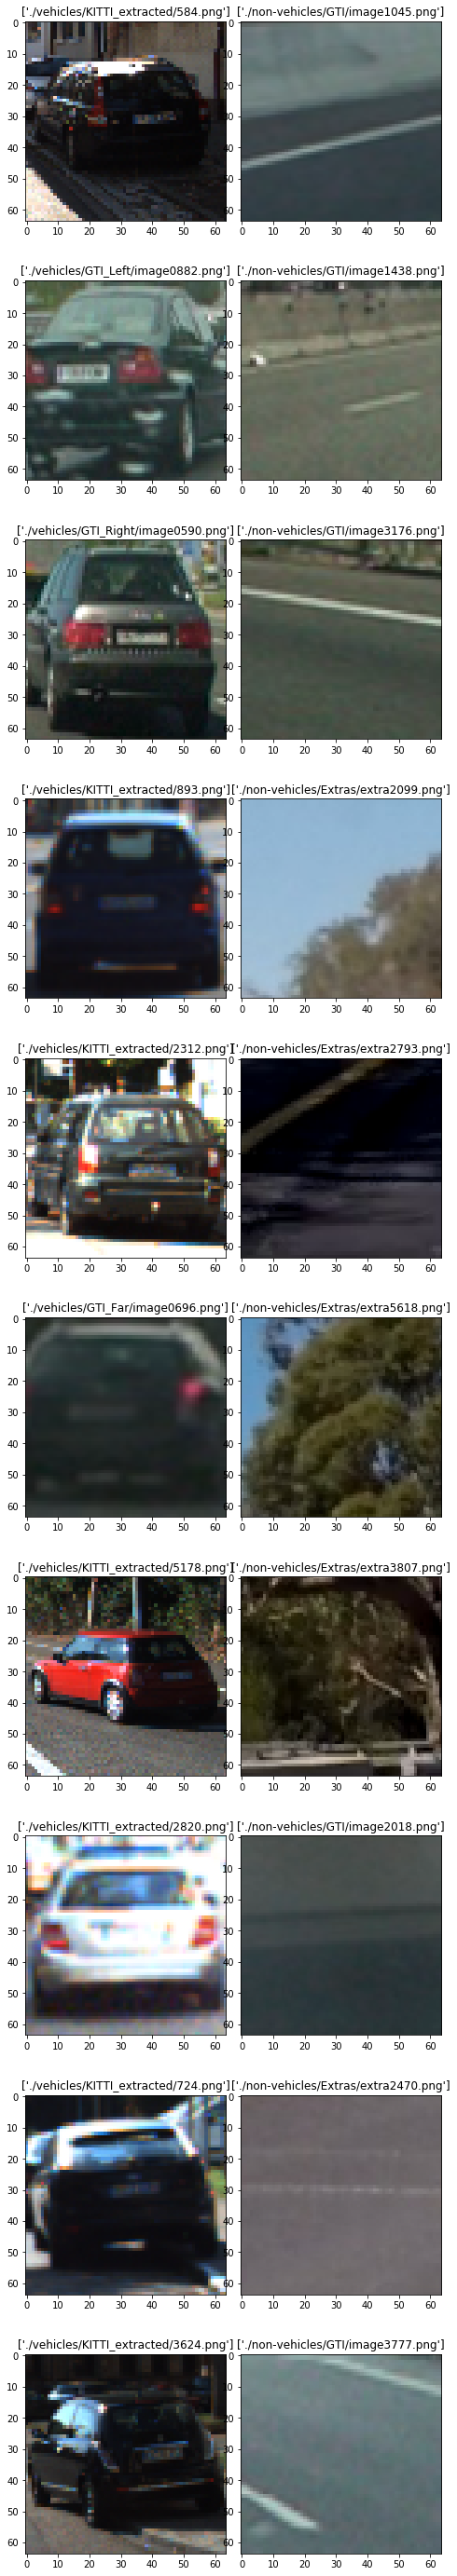

In [19]:
showImageList(images_list, images_label,cols=2,fig_size=(8, 50) )

In [21]:
# Setup Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, 650] # Min and max in y to search in slide_window()

# HOG HELPER function

In [17]:
# Define a function to return HOG features and visualization

gray_ops = lambda im: cv2.cvtColor(im , cv2.COLOR_RGB2GRAY)
YCrCb_ops = lambda im : cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)

In [18]:
hog_ops = lambda im:get_hog_features(im, orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)

### pick up just top randowm 10 
***
To reduce ruunning time on notebook, I have just only 10 images for testing HOG images.

## HOG against Gray image 

In [24]:
gray_images = list(map(gray_ops,car_images)   )
hog_results = np.array( list(map( hog_ops, gray_images )) )

/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


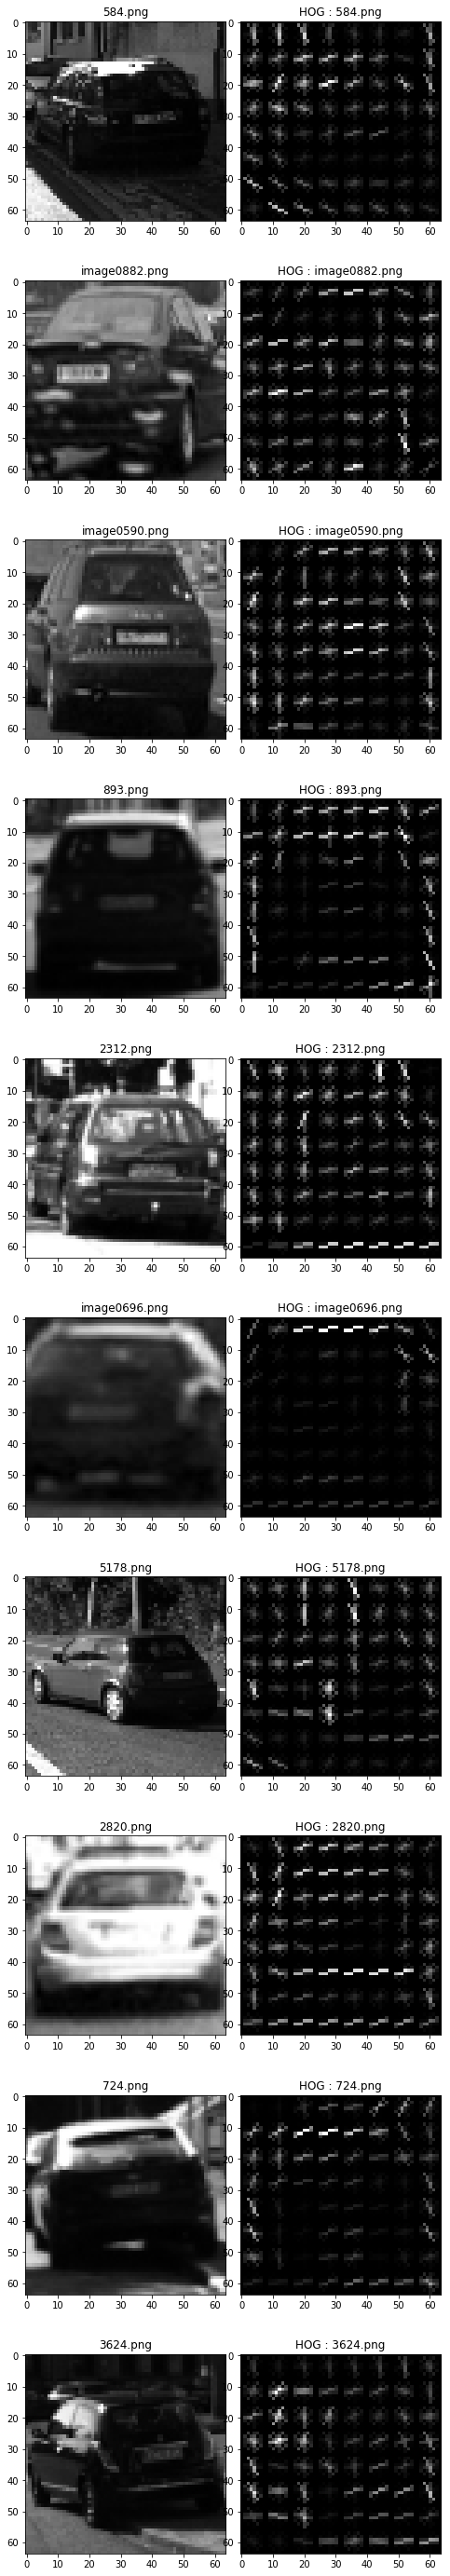

In [25]:
images_list =  np.asarray(list( zip( gray_images, hog_results[:,1]) ))

hcarf = ["HOG : " + f for f in car_filename]
images_label =  np.asarray(list( zip( car_filename, hcarf  ) ))
showImageList(images_list, images_label,cols=2,fig_size=(8, 50) )

## HOG against YCrCb all channels

In [28]:
YCrCb_images = list(map(YCrCb_ops,car_images)   )
ncYCrCb_images = list(map(YCrCb_ops,non_car_images)   )

YCrCb_images_0 = [i[:,:,0] for i in YCrCb_images]
YCrCb_images_1 = [i[:,:,1] for i in YCrCb_images]
YCrCb_images_2 = [i[:,:,2] for i in YCrCb_images]

ncYCrCb_images_0 = [i[:,:,0] for i in ncYCrCb_images]
ncYCrCb_images_1 = [i[:,:,1] for i in ncYCrCb_images]
ncYCrCb_images_2 = [i[:,:,2] for i in ncYCrCb_images]

hog_results_y = np.array( list(map( hog_ops, YCrCb_images_0 )) )
hog_results_cr = np.array( list(map( hog_ops, YCrCb_images_1 )) )
hog_results_cb = np.array( list(map( hog_ops, YCrCb_images_2 )) )

nchog_results_y = np.array( list(map( hog_ops, ncYCrCb_images_0 )) )
nchog_results_cr = np.array( list(map( hog_ops, ncYCrCb_images_1 )) )
nchog_results_cb = np.array( list(map( hog_ops, ncYCrCb_images_2 )) )


y_n_f = ["Y ch.: " + f for f in car_filename]
y_h_f = ["Y HOG: " + f for f in car_filename]
cr_n_f = ["Cr ch.: " + f for f in car_filename]
cr_h_f = ["Cr HOG: " + f for f in car_filename]
cb_n_f = ["Cb ch.: " + f for f in car_filename]
cb_h_f = ["Cb HOG: " + f for f in car_filename]

ncy_n_f = ["Y ch.: " + f for f in non_car_filename]
ncy_h_f = ["Y HOG: " + f for f in non_car_filename]
nccr_n_f = ["Cr ch.: " + f for f in non_car_filename]
nccr_h_f = ["Cr HOG: " + f for f in non_car_filename]
nccb_n_f = ["Cb ch.: " + f for f in non_car_filename]
nccb_h_f = ["Cb HOG: " + f for f in non_car_filename]


/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


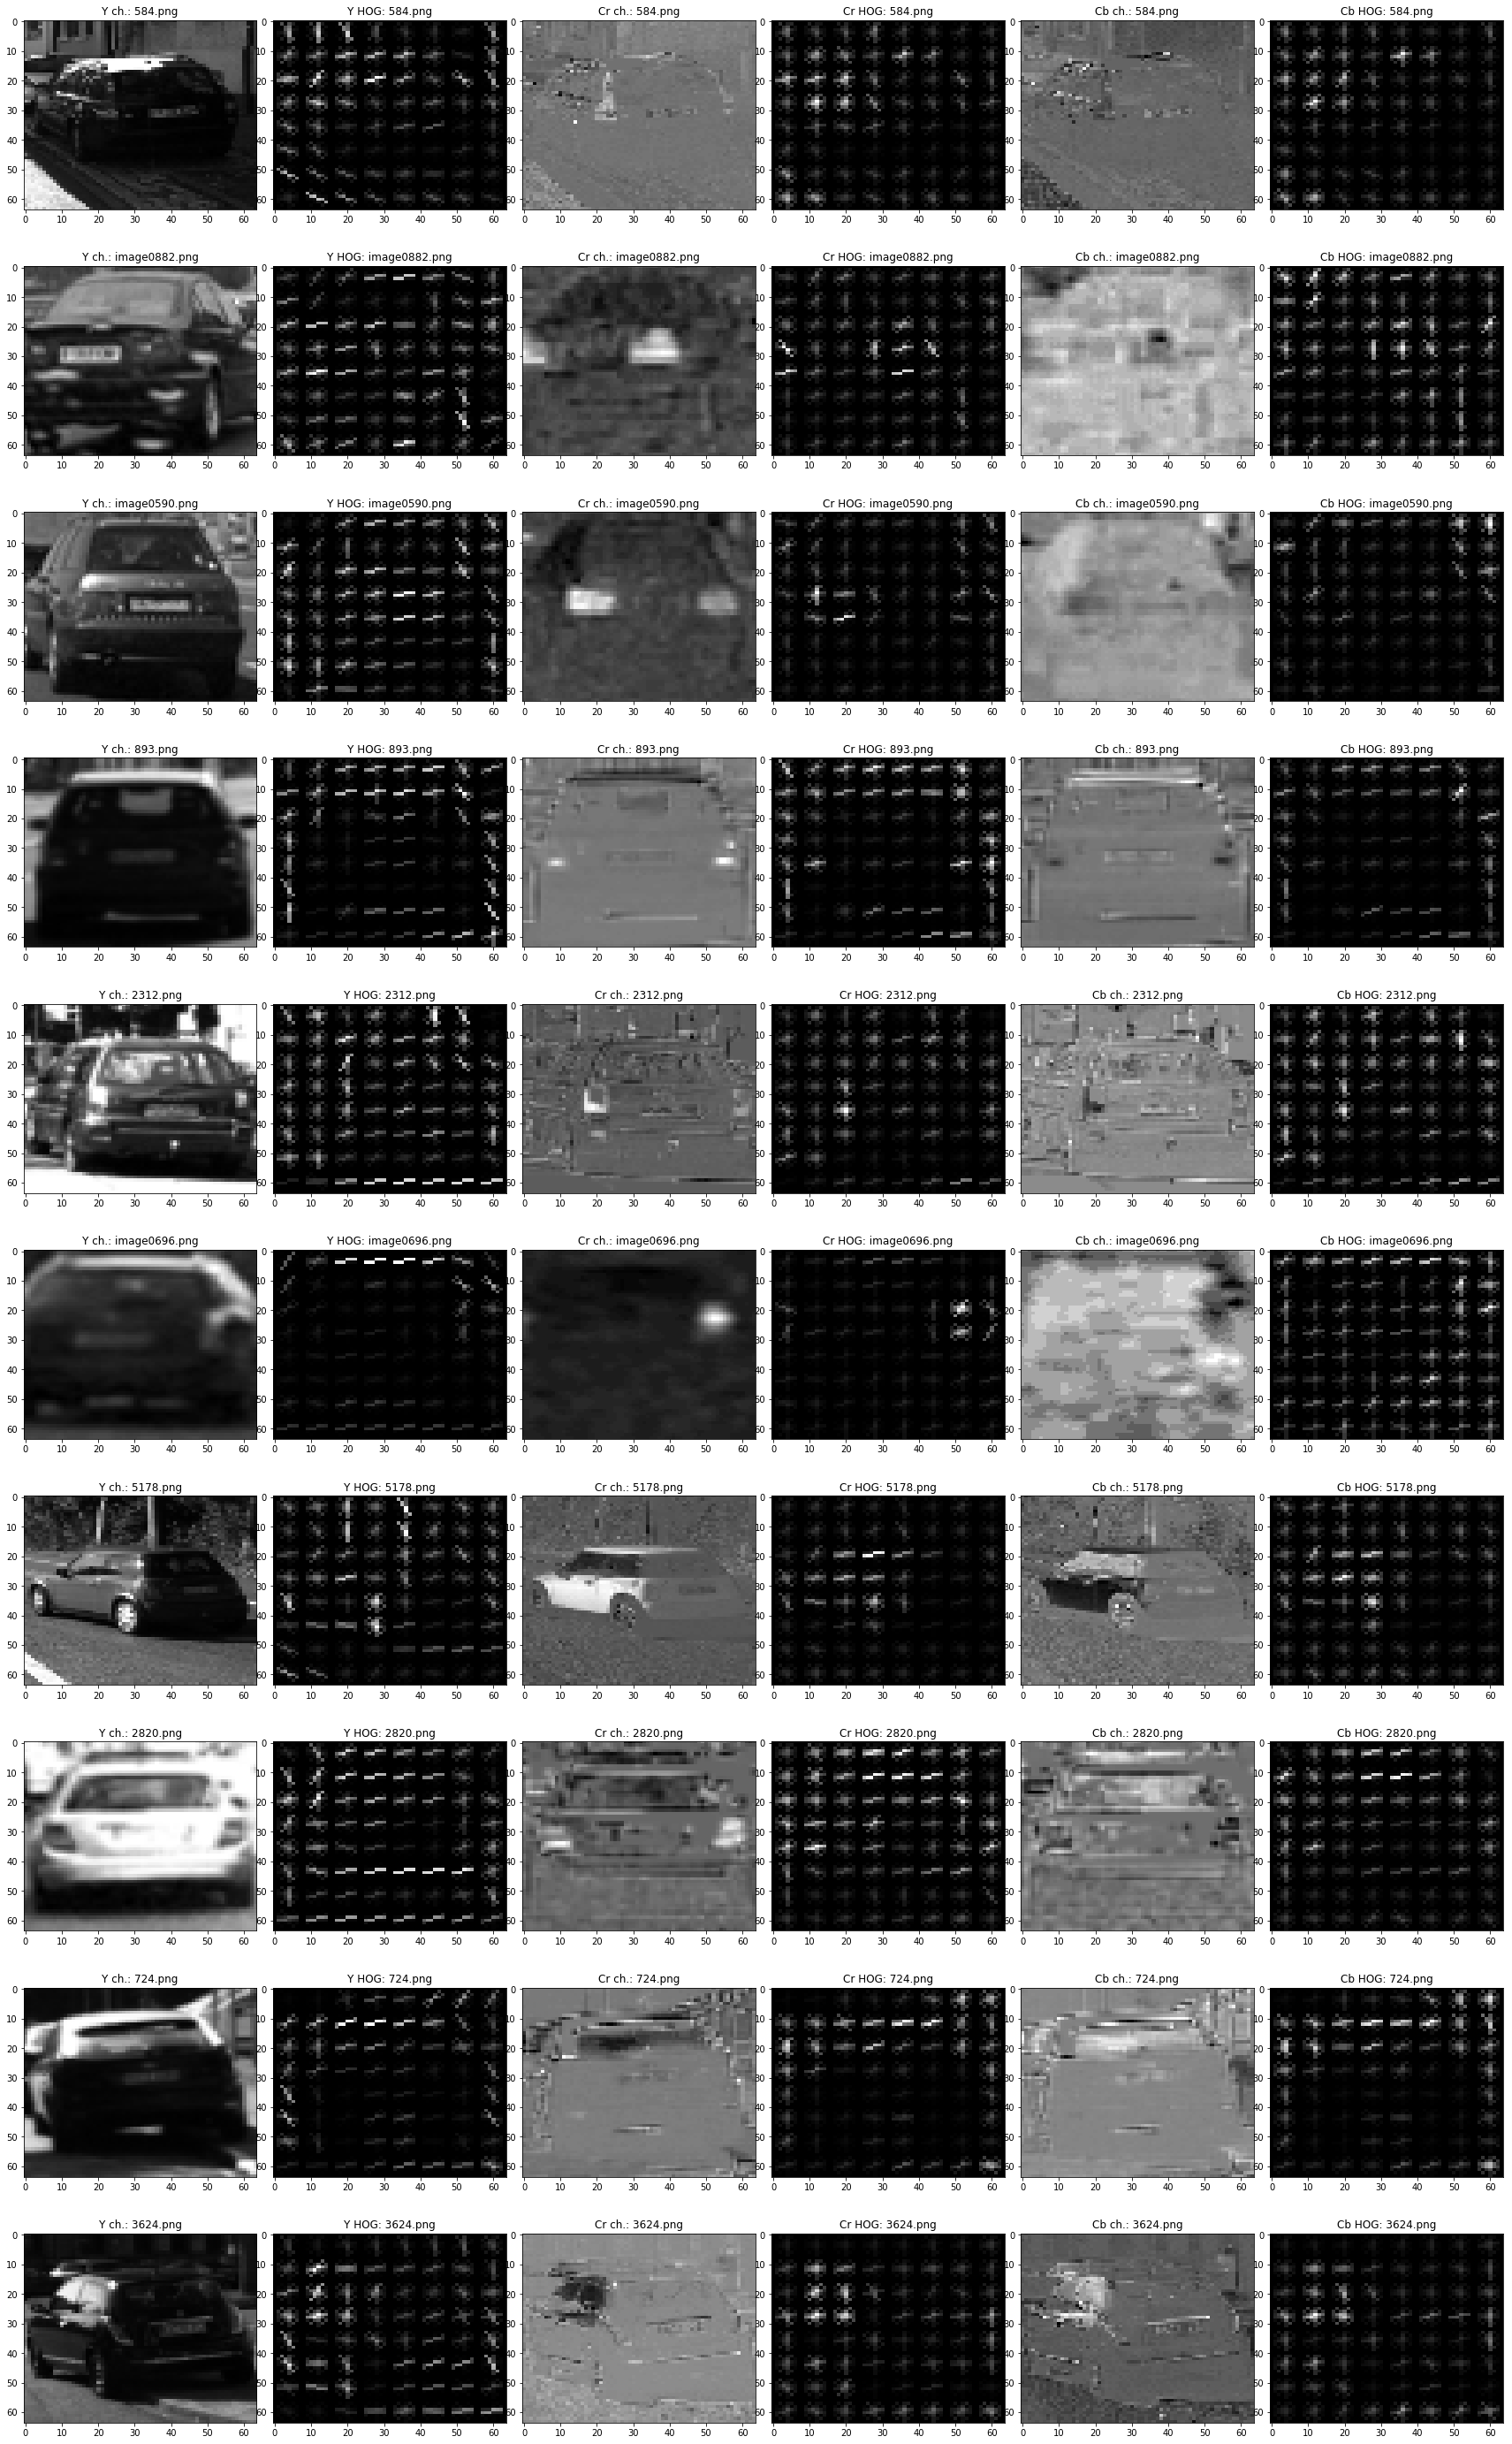

In [27]:
images_list =  np.asarray(list( zip( YCrCb_images_0, hog_results_y[:,1],YCrCb_images_1, hog_results_cr[:,1],YCrCb_images_2, hog_results_cb[:,1] ) )     )   
images_label =  np.asarray(list( zip( y_n_f, y_h_f, cr_n_f, cr_h_f, cb_n_f, cb_h_f  ) ))

showImageList(images_list, images_label,cols=6,fig_size=(30, 50) )

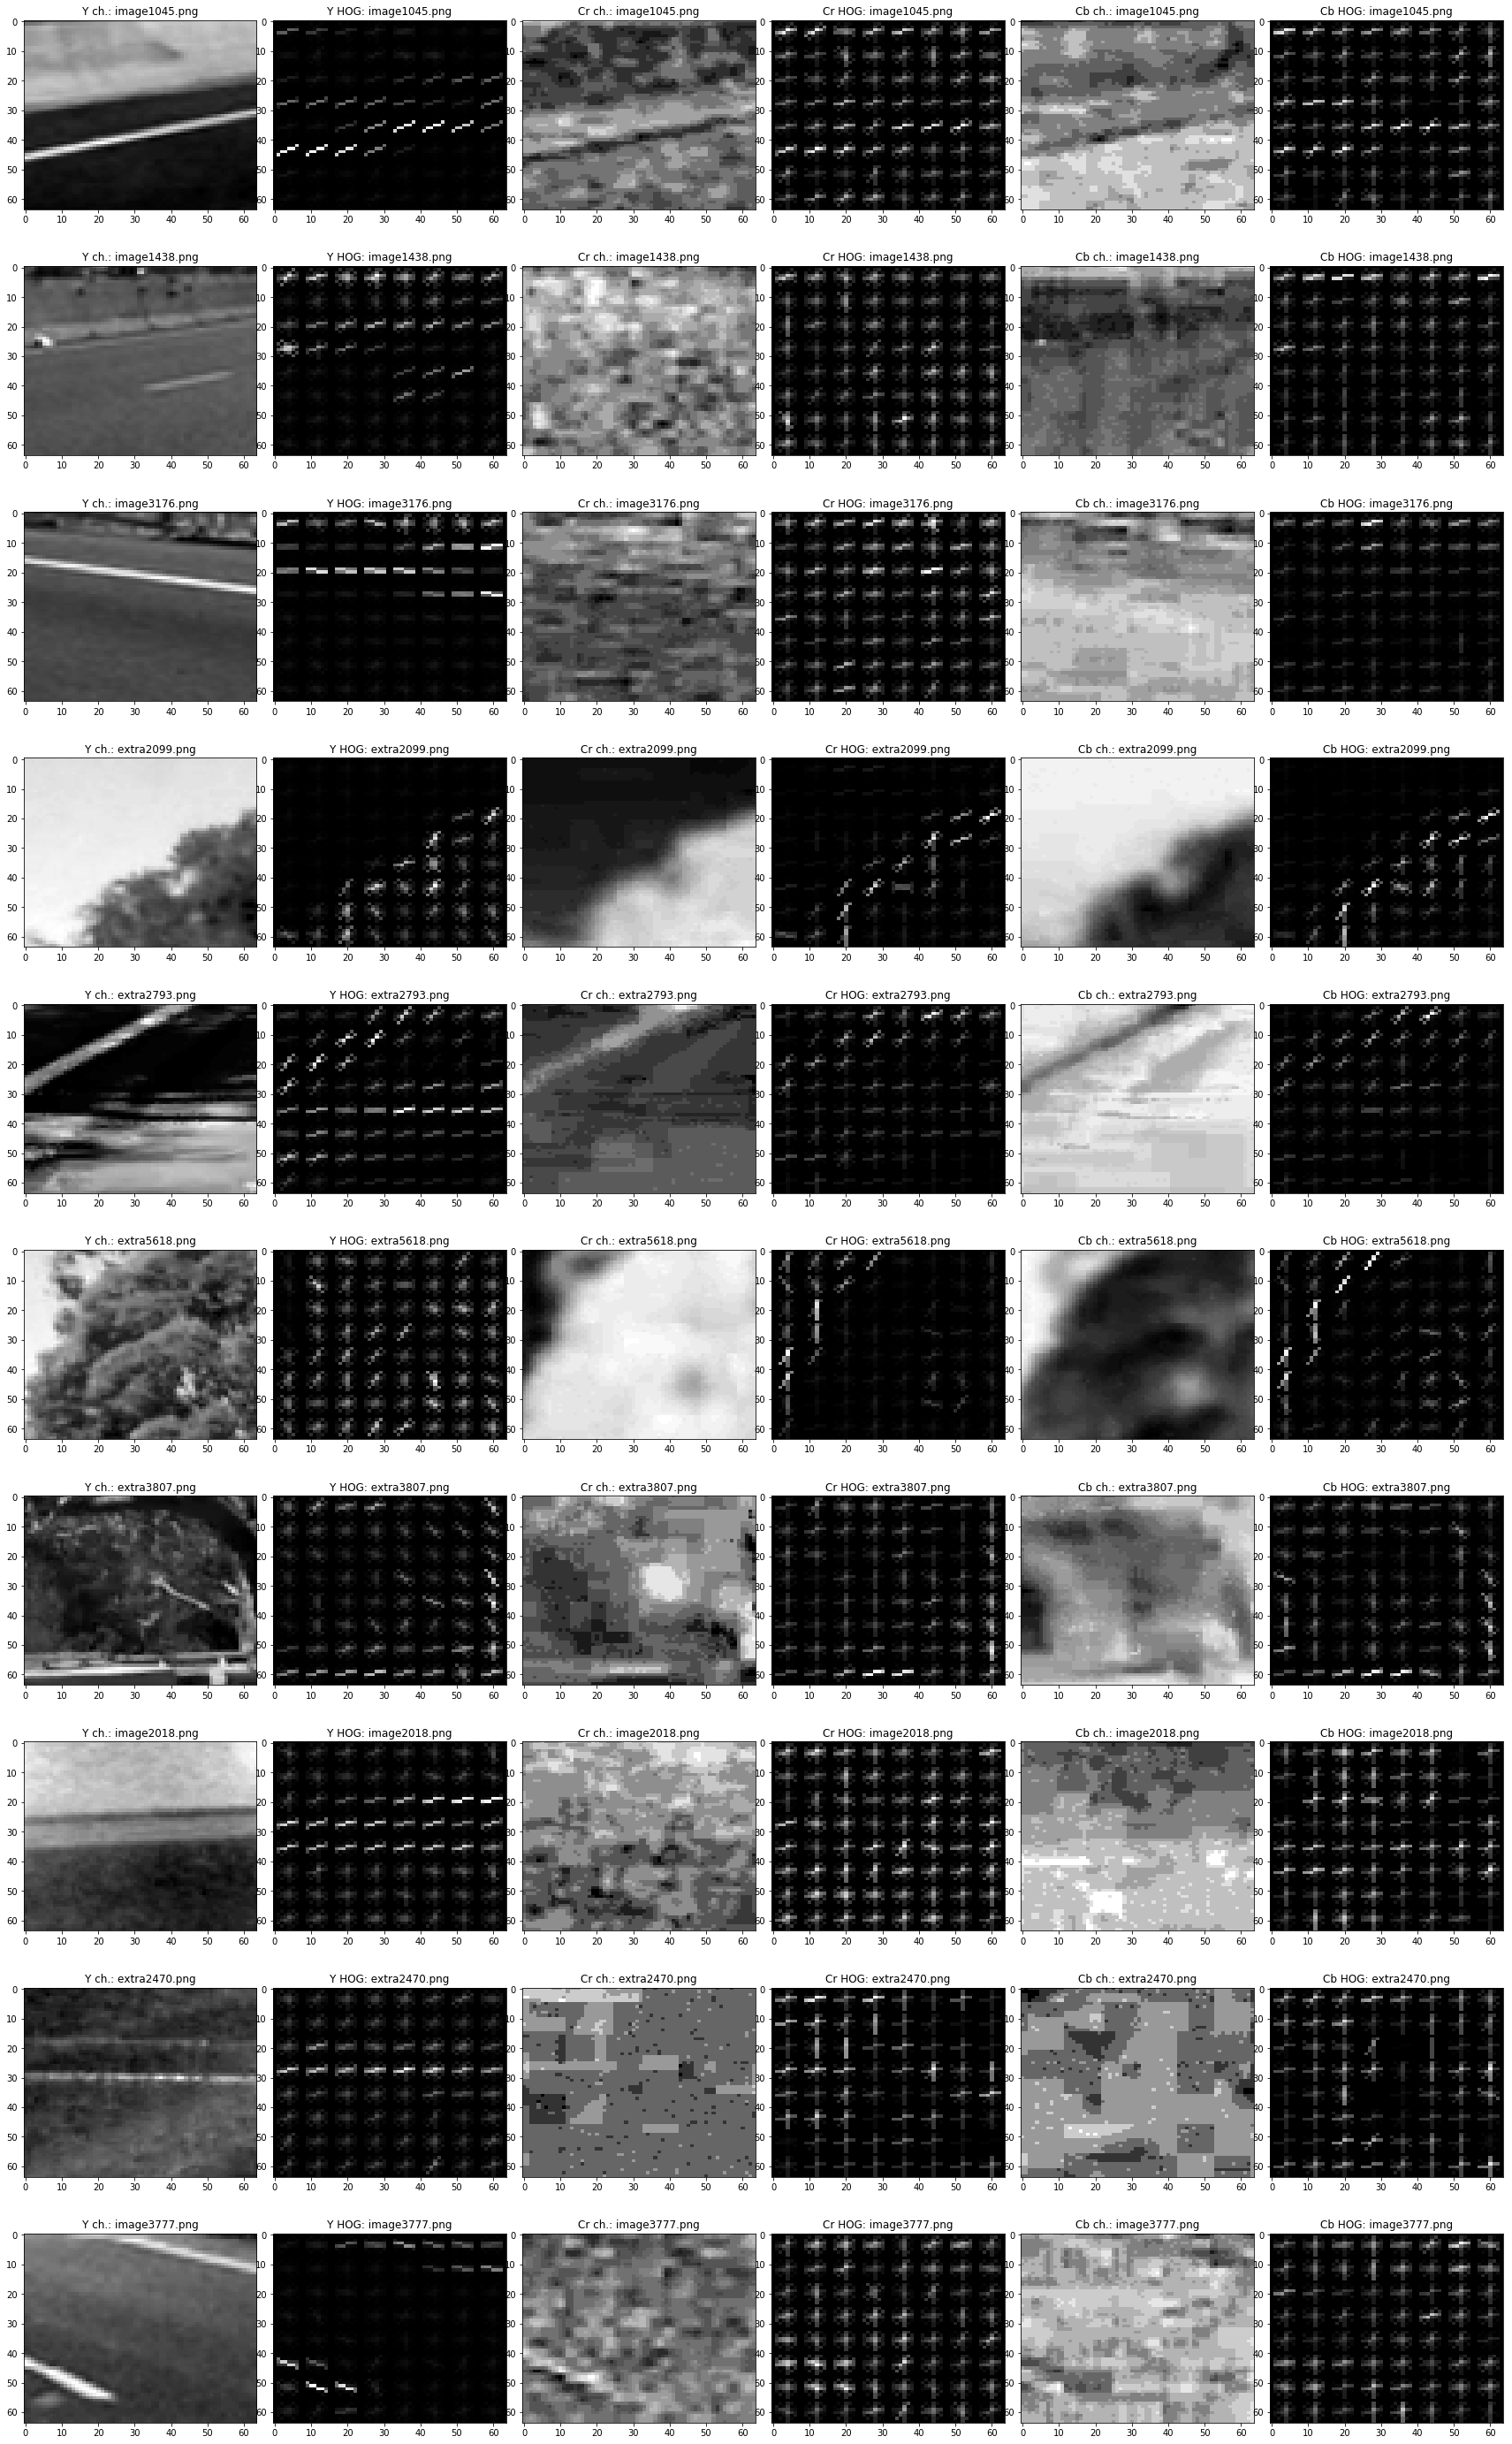

In [29]:
ncimages_list =  np.asarray(list( zip( ncYCrCb_images_0, nchog_results_y[:,1], ncYCrCb_images_1, nchog_results_cr[:,1], ncYCrCb_images_2, nchog_results_cb[:,1] ) )     )   
ncimages_label =  np.asarray(list( zip( ncy_n_f, ncy_h_f, nccr_n_f, nccr_h_f, nccb_n_f, nccb_h_f  ) ))

showImageList(ncimages_list, ncimages_label,cols=6,fig_size=(30, 50) )

## Change pix_per_cell to 4 for HOG image 

In [32]:
orient = 9  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_ops = lambda im:get_hog_features(im, orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_results_y = np.array( list(map( hog_ops, YCrCb_images_0 )) )
hog_results_cr = np.array( list(map( hog_ops, YCrCb_images_1 )) )
hog_results_cb = np.array( list(map( hog_ops, YCrCb_images_2 )) )

nchog_results_y = np.array( list(map( hog_ops, ncYCrCb_images_0 )) )
nchog_results_cr = np.array( list(map( hog_ops, ncYCrCb_images_1 )) )
nchog_results_cb = np.array( list(map( hog_ops, ncYCrCb_images_2 )) )

/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


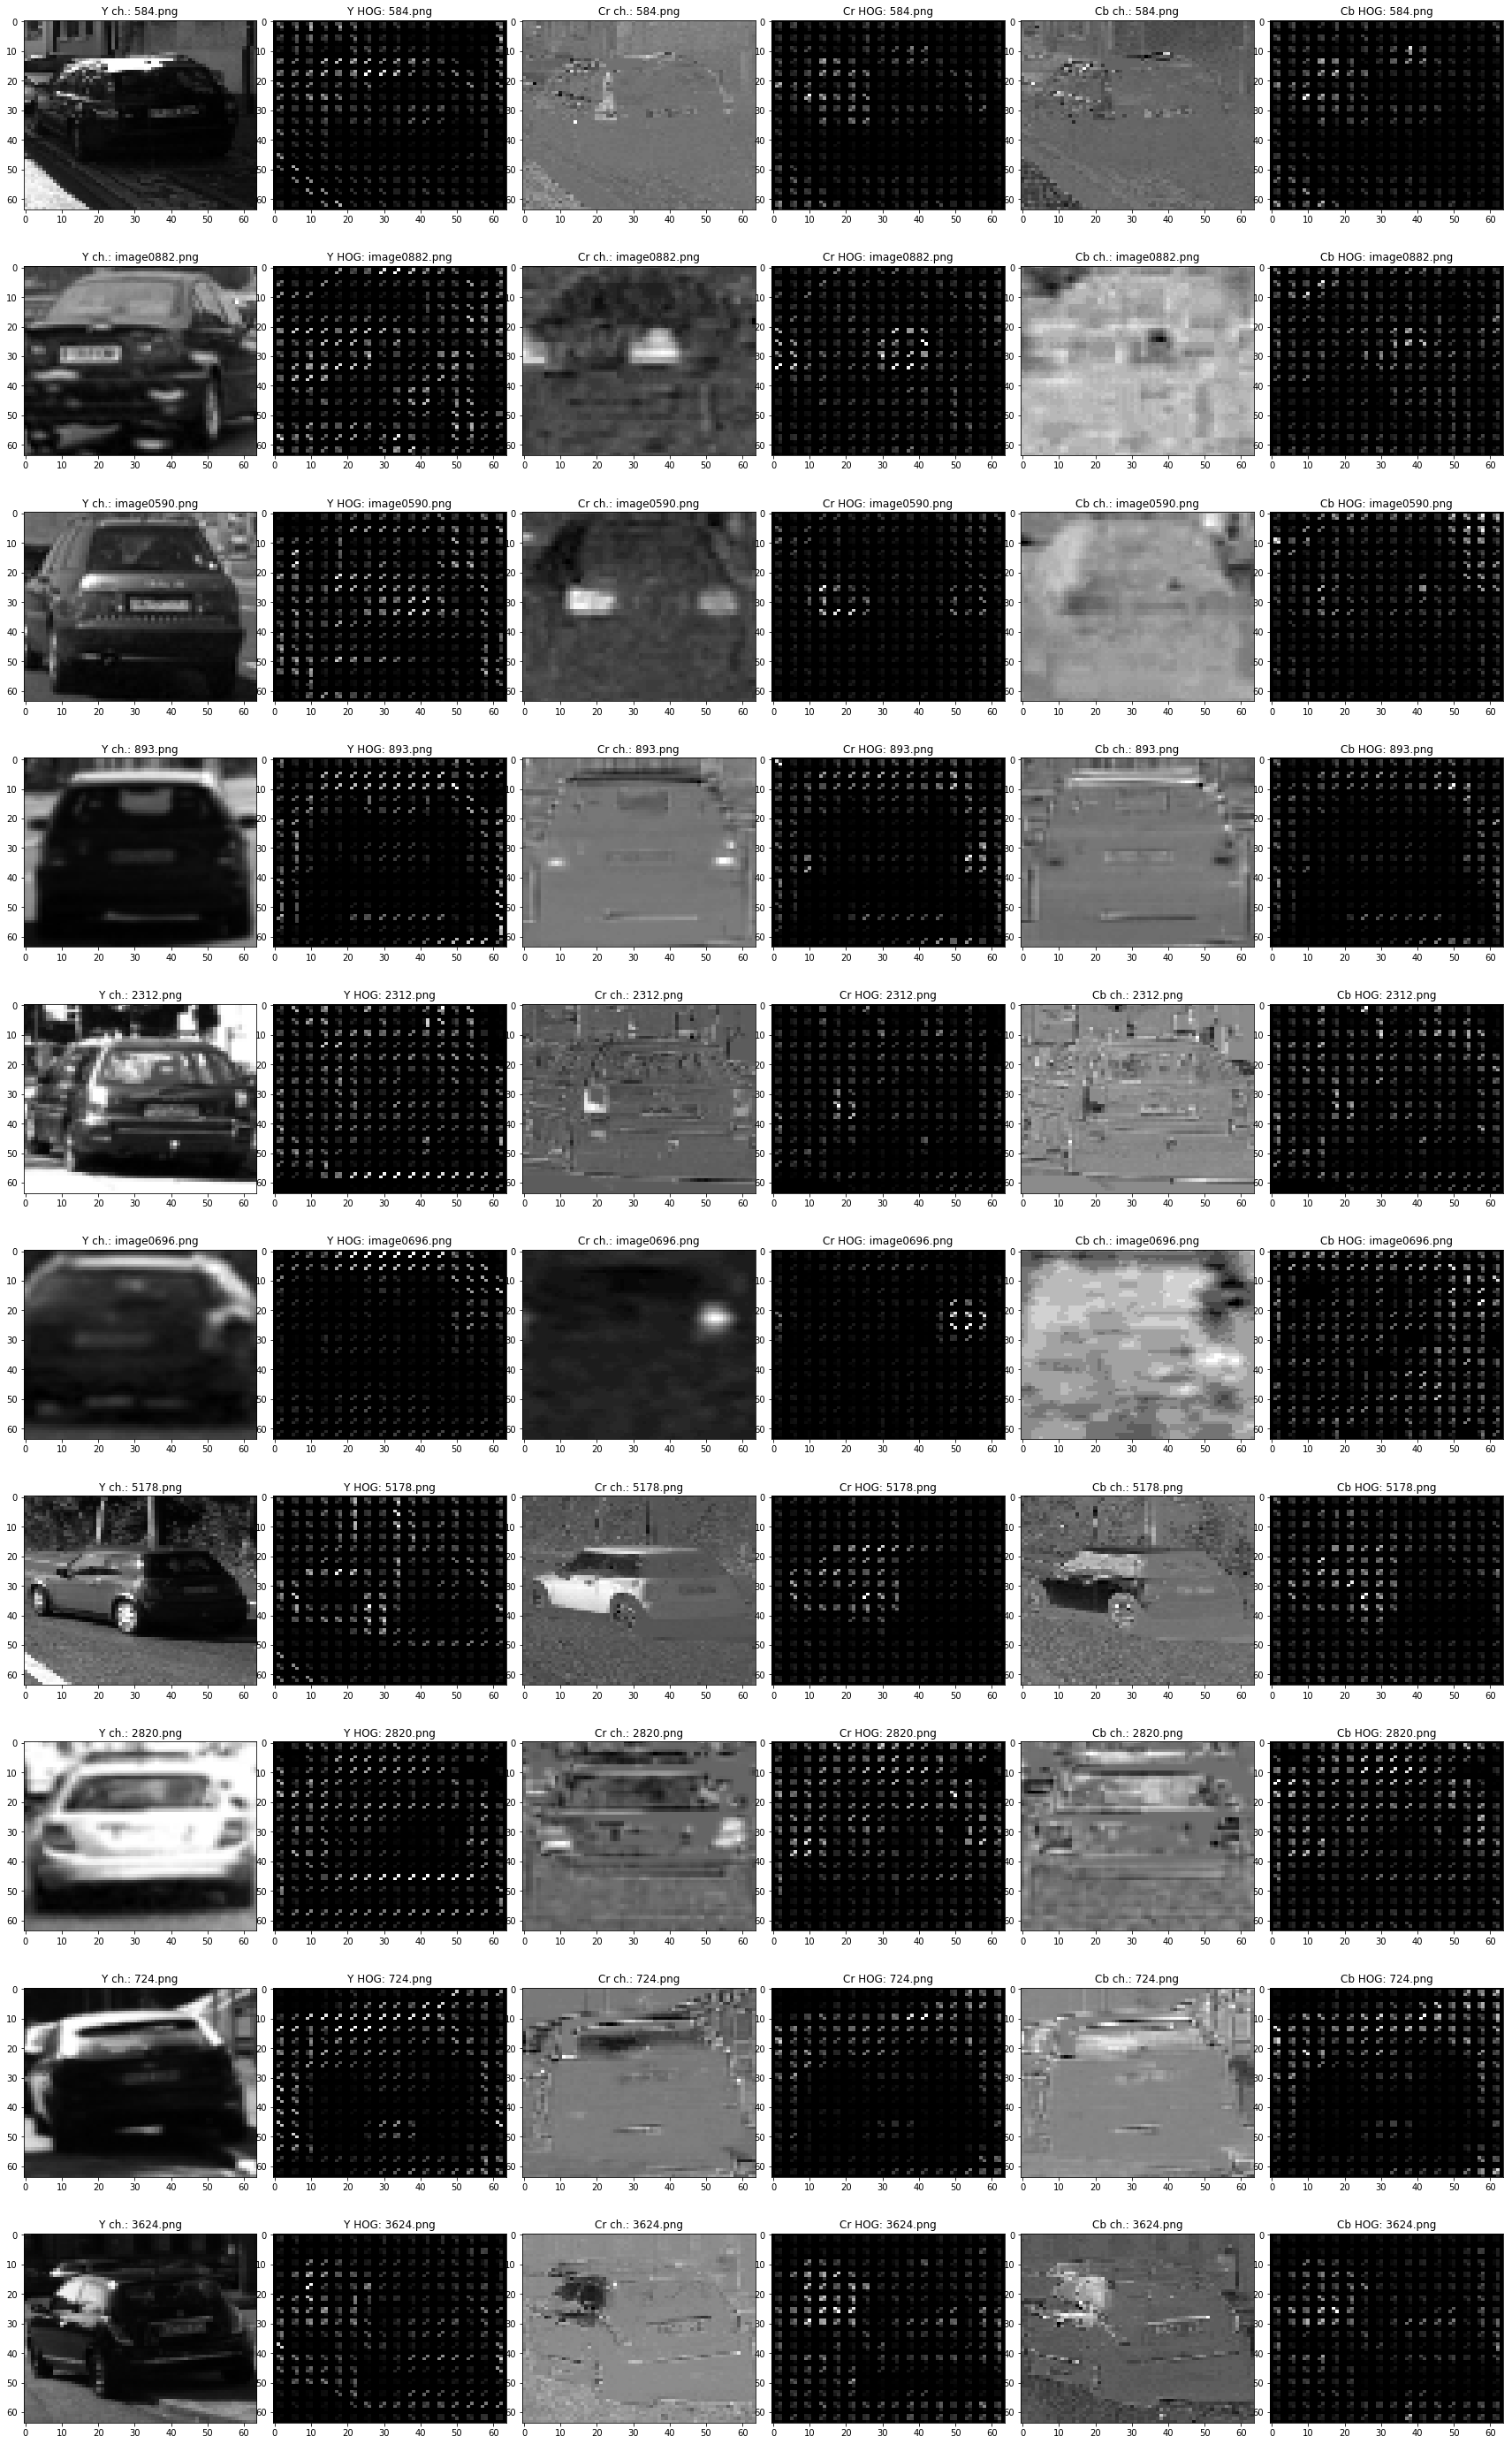

In [33]:
images_list =  np.asarray(list( zip( YCrCb_images_0, hog_results_y[:,1],YCrCb_images_1, hog_results_cr[:,1],YCrCb_images_2, hog_results_cb[:,1] ) )     )   
images_label =  np.asarray(list( zip( y_n_f, y_h_f, cr_n_f, cr_h_f, cb_n_f, cb_h_f  ) ))

showImageList(images_list, images_label,cols=6,fig_size=(30, 50) )

# Color Feature Extraction #

In [13]:
## function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    ## compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    ## generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    ## concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # return the individual histograms, bin_centers, and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [14]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    ## convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    
    ## use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    return features

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

In [16]:
## function to extract features
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=False, color_feat=False, hog_feat=True):
    ## create a list to append feature vectors to
    features = []
    
    ## iterate through the list of images
    for img in imgs:
        ## image features
        img_features = []
        
        ## read in each one by one
        #img = mpimg.imread(file)
        
        ## apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)      
        
        ## get spatial binning features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        
        ## get color features
        if color_feat:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        
        if hog_feat:
            ## get hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
            
        ## append features to overall feature set
        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

## function to extract features from a single image
def single_img_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, color_feat=True, hog_feat=True):    
    
    ## define an empty list to receive features
    img_features = []
    
    ## apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    ## spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    ## color features
    if color_feat:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    ## HOG features
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        ## append features to list
        img_features.append(hog_features)

    ## return concatenated array of features
    return np.concatenate(img_features)

In [17]:
color_space="YCrCb"
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

t=time.time()
## extract vehicle image features
car_features = extract_features(car_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)

notcar_features = extract_features(non_car_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   color_feat=color_feat, hog_feat=hog_feat)



/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [18]:
np.array(car_features).shape, np.array(notcar_features).shape

((8792, 5568), (8968, 5568))

## Build Training Data set for Can & Non Car

In [19]:
# first of all build label data for y

# 1 ---> CAR
# 
# 0 ---> NON CAR 
#
# total length 8792 + 8968 = 17760
#

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))


In [21]:
# 
# next, build X training data 
#

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## X features of RGB image (raw image / histgram)

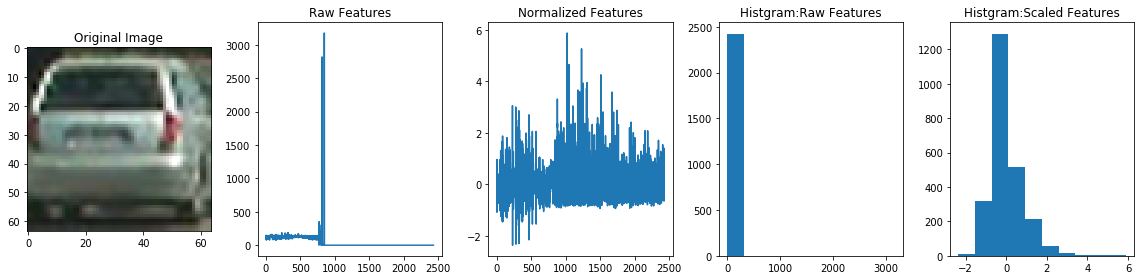

In [39]:
car_ind = np.random.randint(0, len(car_features))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(16,4))
plt.subplot(151)
plt.imshow( car_images[car_ind] )
plt.title('Original Image')
plt.subplot(152)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(153)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')

plt.subplot(154)
plt.hist(X[car_ind])
plt.title('Histgram:Raw Features')

plt.subplot(155)
plt.hist(scaled_X[car_ind])
plt.title('Histgram:Scaled Features')

fig.tight_layout()

## X features of YCrCb image (raw image / histgram)

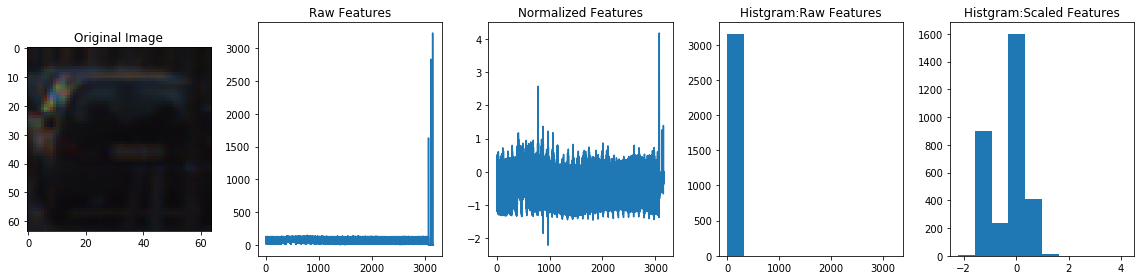

In [47]:
X_conv = np.vstack((car_features_conv, notcar_features_conv)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler_conv = StandardScaler().fit(X_conv)
# Apply the scaler to X
scaled_X_conv = X_scaler_conv.transform(X_conv)

car_ind = np.random.randint(0, len(car_features))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(16,4))
plt.subplot(151)
plt.imshow( car_images[car_ind] )
plt.title('Original Image')
plt.subplot(152)
plt.plot(X_conv[car_ind])
plt.title('Raw Features')
plt.subplot(153)
plt.plot(scaled_X_conv[car_ind])
plt.title('Normalized Features')

plt.subplot(154)
plt.hist(X_conv[car_ind])
plt.title('Histgram:Raw Features')

plt.subplot(155)
plt.hist(scaled_X_conv[car_ind])
plt.title('Histgram:Scaled Features')

fig.tight_layout()